In [81]:
import tensorflow as tf
print(tf.__version__)

2.3.0


In [82]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, LSTM, Flatten
from tensorflow.keras.optimizers import Adam

In [83]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [84]:
from sklearn.preprocessing import StandardScaler

### Load Dataset

In [85]:
df = pd.read_csv('https://raw.githubusercontent.com/lazyprogrammer/machine_learning_examples/master/tf2.0/sbux.csv')

In [86]:
df.head()

,date,open,high,low,close,volume,Name
0,2013-02-08,27.920,28.325,27.920,28.185,7146296,SBUX
1,2013-02-11,28.260,28.260,27.930,28.070,5457354,SBUX
2,2013-02-12,28.000,28.275,27.975,28.130,8665592,SBUX
3,2013-02-13,28.230,28.230,27.750,27.915,7022056,SBUX
4,2013-02-14,27.765,27.905,27.675,27.775,8899188,SBUX


In [87]:
df.tail()

,date,open,high,low,close,volume,Name
1254,2018-02-01,56.280,56.42,55.89,56.00,14690146,SBUX
1255,2018-02-02,55.900,56.32,55.70,55.77,15358909,SBUX
1256,2018-02-05,55.530,56.26,54.57,54.69,16059955,SBUX
1257,2018-02-06,53.685,56.06,53.56,55.61,17415065,SBUX
1258,2018-02-07,55.080,55.43,54.44,54.46,13927022,SBUX


### Data Preparing

*it's too hard to predict the price or return (regression problem), so try to predict simplest problem -> binary classification price direction*

Compute target

In [88]:
# compute returns
df['prev_close'] = df['close'].shift(1)
df.head()

,date,open,high,low,close,volume,Name,prev_close
0,2013-02-08,27.920,28.325,27.920,28.185,7146296,SBUX,NaN
1,2013-02-11,28.260,28.260,27.930,28.070,5457354,SBUX,28.185
2,2013-02-12,28.000,28.275,27.975,28.130,8665592,SBUX,28.070
3,2013-02-13,28.230,28.230,27.750,27.915,7022056,SBUX,28.130
4,2013-02-14,27.765,27.905,27.675,27.775,8899188,SBUX,27.915


In [89]:
df['returns'] = (df['close'] - df['prev_close']) / df['prev_close']
df.head()

,date,open,high,low,close,volume,Name,prev_close,returns
0,2013-02-08,27.920,28.325,27.920,28.185,7146296,SBUX,NaN,NaN
1,2013-02-11,28.260,28.260,27.930,28.070,5457354,SBUX,28.185,-0.004080
2,2013-02-12,28.000,28.275,27.975,28.130,8665592,SBUX,28.070,0.002138
3,2013-02-13,28.230,28.230,27.750,27.915,7022056,SBUX,28.130,-0.007643
4,2013-02-14,27.765,27.905,27.675,27.775,8899188,SBUX,27.915,-0.005015


In [90]:
df['target'] = (df['returns'] > 0).astype(int)
df.head()

,date,open,high,low,close,volume,Name,prev_close,returns,target
0,2013-02-08,27.920,28.325,27.920,28.185,7146296,SBUX,NaN,NaN,0
1,2013-02-11,28.260,28.260,27.930,28.070,5457354,SBUX,28.185,-0.004080,0
2,2013-02-12,28.000,28.275,27.975,28.130,8665592,SBUX,28.070,0.002138,1
3,2013-02-13,28.230,28.230,27.750,27.915,7022056,SBUX,28.130,-0.007643,0
4,2013-02-14,27.765,27.905,27.675,27.775,8899188,SBUX,27.915,-0.005015,0


Selecting features

In [91]:
X = df[['open', 'high', 'low', 'close', 'volume']].values
y = df['target'].values

In [92]:
X.shape

(1259, 5)

In [93]:
y.shape

(1259,)

Scaling and split data

In [94]:
T = 10
N = len(X)

In [95]:
N_train = len(X) * 2//3
scaler = StandardScaler()
scaler.fit(X[:N_train+T])
X = scaler.transform(X)

In [96]:
X_train = []
y_train = []

for i in range(T, N_train):
    X_train.append(X[i-T:i])
    y_train.append(y[i])

X_train = np.array(X_train)
y_train = np.array(y_train)

print(f'X_train shape: {X_train.shape}')
print(f'y_train shape: {y_train.shape}')

X_train shape: (829, 10, 5)
y_train shape: (829,)


In [97]:
X_test = []
y_test = []

for i in range(N_train + T, N):
    X_test.append(X[i-T:i])
    y_test.append(y[i])

X_test = np.array(X_test)
y_test = np.array(y_test)

print(f'X_test shape: {X_test.shape}')
print(f'y_test shape: {y_test.shape}')

X_test shape: (410, 10, 5)
y_test shape: (410,)


### Train Model

In [98]:
i = Input(shape=X_train.shape[1:])
x = LSTM(50)(i)
x = Dense(1, activation='sigmoid')(x)

In [99]:
model = Model(i, x)
model.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 10, 5)]           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 50)                11200     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 51        
Total params: 11,251
Trainable params: 11,251
Non-trainable params: 0
_________________________________________________________________


In [100]:
model.compile(optimizer=Adam(lr=0.001), loss='binary_crossentropy', metrics=['accuracy'])

In [101]:
r = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=300)

Epoch 1/300
26/26 [==============================] - 1s 20ms/step - loss: 0.6966 - accuracy: 0.4825 - val_loss: 0.6942 - val_accuracy: 0.4854
Epoch 2/300
26/26 [==============================] - 0s 6ms/step - loss: 0.6946 - accuracy: 0.5271 - val_loss: 0.6973 - val_accuracy: 0.4854
Epoch 3/300
26/26 [==============================] - 0s 6ms/step - loss: 0.6941 - accuracy: 0.5006 - val_loss: 0.6930 - val_accuracy: 0.4976
Epoch 4/300
26/26 [==============================] - 0s 6ms/step - loss: 0.6936 - accuracy: 0.5127 - val_loss: 0.6936 - val_accuracy: 0.4951
Epoch 5/300
26/26 [==============================] - 0s 6ms/step - loss: 0.6936 - accuracy: 0.5235 - val_loss: 0.6956 - val_accuracy: 0.4927
Epoch 6/300
26/26 [==============================] - 0s 6ms/step - loss: 0.6921 - accuracy: 0.4994 - val_loss: 0.6930 - val_accuracy: 0.4902
Epoch 7/300
26/26 [==============================] - 0s 6ms/step - loss: 0.6902 - accuracy: 0.5380 - val_loss: 0.6931 - val_accuracy: 0.4902
Epoch 8/300


### Model Evaluation

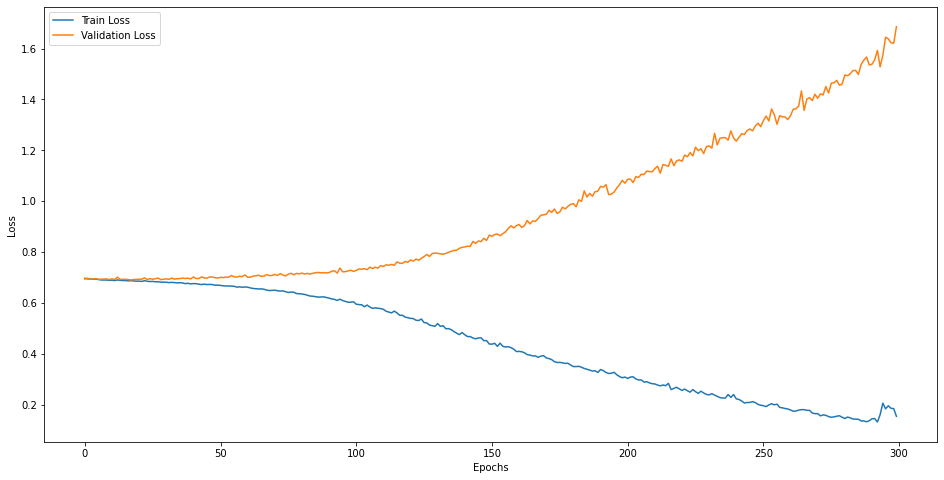

In [102]:
plt.figure(figsize=(16, 8))
plt.plot(r.history['loss'], label='Train Loss')
plt.plot(r.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

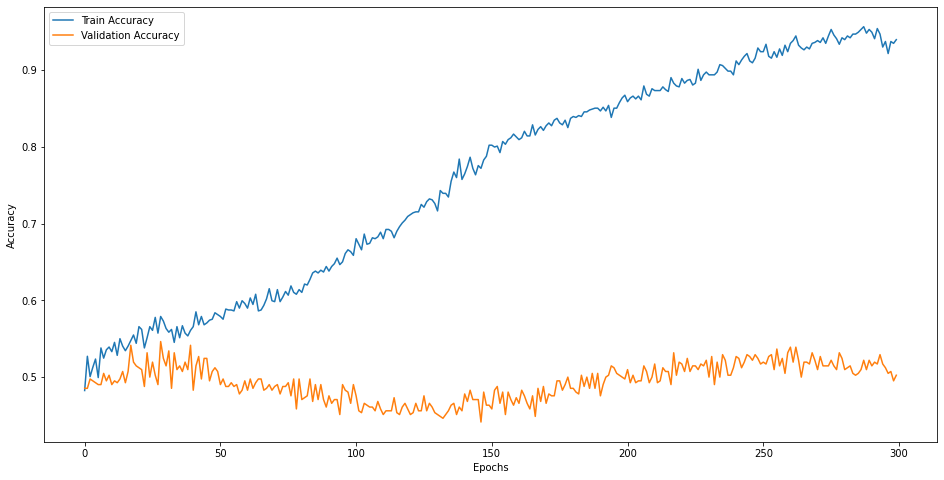

In [103]:
plt.figure(figsize=(16, 8))
plt.plot(r.history['accuracy'], label='Train Accuracy')
plt.plot(r.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()